前置設定

In [12]:
# ===== 基礎 =====
import os, re, numpy as np, pandas as pd
from scipy import sparse as sp
from bs4 import BeautifulSoup

# Sklearn
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag, word_tokenize, ne_chunk

# 其他
from joblib import Parallel, delayed
from math import ceil
from sklearn.preprocessing import normalize


# ===== 路徑與隨機種子 =====
DATA_DIR = './dataset'
TRAIN_PATH = f'{DATA_DIR}/train.csv'
TEST_PATH  = f'{DATA_DIR}/test.csv'
OUT_DIR = './output'
os.makedirs(OUT_DIR, exist_ok=True)
np.random.seed(42)

# ===== 速度開關（訓練時可先關慢模塊）=====
FAST_NO_NER = True        # 關 NER
FAST_NO_LDA = True        # 關 LDA 主題
FAST_NO_TEXTSTAT = True   # 關可讀性評分

# ===== NLTK 資源（缺什麼補什麼）=====
for rid, name in [
    ('tokenizers/punkt', 'punkt'),
    ('corpora/stopwords', 'stopwords'),
    ('corpora/wordnet', 'wordnet'),
    ('sentiment/vader_lexicon', 'vader_lexicon'),
    ('taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger'),
    ('chunkers/maxent_ne_chunker', 'maxent_ne_chunker'),
    ('corpora/words', 'words'),
]:
    try:
        nltk.data.find(rid)
    except LookupError:
        nltk.download(name)

# 全局 VADER（避免每條樣本重建）
try:
    VADER = SentimentIntensityAnalyzer()
except Exception:
    VADER = None


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


導入數據與切分

In [2]:
# 將 Popularity {-1,1} → {0,1}；並切出 train/val
df_all = pd.read_csv(TRAIN_PATH)
df_all['Popularity'] = (df_all['Popularity'].astype(int) == 1).astype(int)

TRAIN_SIZE = 24000
VAL_SIZE   = 3000

train_df = df_all.iloc[:TRAIN_SIZE].reset_index(drop=True)
val_df   = df_all.iloc[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE].reset_index(drop=True)

print(train_df.shape, val_df.shape)
train_df.head(2)


(24000, 3) (3000, 3)


,Id,Popularity,Page content
0,0,0,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."


工具函數

In [4]:
# 小工具
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\b'
    r'(?:article-content|article-body|content-body|post-content)\b[^>]*>'
)
_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s: str) -> str:
    return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()

def _slug(s: str) -> str:
    return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def _bucket(n, edges):
    if n is None: return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def _aspect_bucket(w, h):
    if not w or not h: return 'unk'
    r = w / h
    if r < 0.9: return 'tall'
    if r < 1.2: return 'squareish'
    if r < 1.8: return 'landscape'
    return 'ultrawide'

def _img_size_bucket(w, h):
    if not w or not h: return 'unk'
    area = (w or 0) * (h or 0)
    if area < 80_000: return 'xs'
    if area < 230_000: return 'sm'
    if area < 920_000: return 'md'
    if area < 2_100_000: return 'lg'
    return 'xl'

def _parse_wh_from_src(src: str):
    if not src: return (None, None)
    m = re.search(r'/(\d{2,5})x(\d{2,5})/', src)
    return (int(m.group(1)), int(m.group(2))) if m else (None, None)

TRENDING_TOPICS = {
    'elon_musk', 'ai', 'climate_change', 'covid', 'blockchain', 'taiwan',
    'tesla', 'space', 'crypto', 'elections'
}

# LDA（可選）
def pretrain_lda(df, column='Page content', n_components=10, max_features=1000, max_text_len=500):
    def extract_text(html):
        if not isinstance(html, str) or not html.strip(): return ""
        m = _BODY_OPEN.search(html)
        header_html = html[:m.start()] if m else html
        soup = BeautifulSoup(header_html, 'html.parser')
        return ' '.join(soup.get_text().lower().split()[:max_text_len])

    corpus = [extract_text(x) for x in df[column].astype(str)]
    if not any(corpus): return None, None
    vec = CountVectorizer(max_features=max_features, stop_words='english')
    X = vec.fit_transform(corpus)
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(X)
    return vec, lda

lda_vectorizer, lda_model = (None, None)
if not FAST_NO_LDA:
    _df_lda = df_all.dropna(subset=['Page content']).astype({'Page content':'str'})
    lda_vectorizer, lda_model = pretrain_lda(_df_lda, 'Page content', n_components=10, max_features=1000)
    print("LDA pretrained")
else:
    print("LDA skipped by FAST_NO_LDA=True")


LDA skipped by FAST_NO_LDA=True


預處理函數

In [5]:
# ====== 幫助函數：清洗 header 文本做詞袋 ======
porter = PorterStemmer()
STOP = set(stopwords.words('english'))

def _bow_clean(txt: str) -> str:
    toks = [w for w in re.findall(r'[A-Za-z]+', (txt or '').lower()) if w not in STOP]
    return ' '.join(porter.stem(w) for w in toks)

# ====== 修正版 preprocessor：回傳 4 個值（多 header_bow_text）======
def preprocessor(html: str, lda_vectorizer=None, lda_model=None, max_text_len=500):
    if not isinstance(html, str) or not html.strip():
        # 也回傳第四個空詞袋
        return "empty_content", set(), "author_unknown channel_unknown publisher_unknown", ""

    # 只取 header
    m = _BODY_OPEN.search(html)
    header_html = html[:m.start()] if m else html
    soup = BeautifulSoup(header_html, 'html.parser')

    # 標題
    title_raw = None
    h1 = soup.find('h1', class_=lambda c: (isinstance(c, list) and any('title' in x for x in c)) or (isinstance(c, str) and 'title' in c)) \
         or soup.find('h1')
    if h1: title_raw = h1.get_text(' ', strip=True)
    elif soup.title: title_raw = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title_raw)

    # 作者 / 頻道 / 發佈者
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by: author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a: author = a.get_text(' ', strip=True)
    author_slug = _slug(re.sub(r'^\s*by\s+', '', author or '', flags=re.I))
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'): channel = art['data-channel']
    if not channel and art:
        cls = ' '.join(art.get('class', []))
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch: channel = mch.group(1)
    channel_slug = _slug(channel or 'unknown')
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub: publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    publisher_slug = _slug(publisher or 'unknown')

    # 時間
    year = month = weekday = tod = season = None
    is_weekend = None
    tm = soup.find('time')
    dt = tm['datetime'] if (tm and tm.has_attr('datetime')) else (tm.get_text(' ', strip=True) if tm else None)
    if dt:
        y = re.search(r'(20\d{2}|19\d{2})', dt);  year = y.group(1) if y else None
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            month = _MONTH.get(mm, mm)
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd: weekday = wd.group(1).lower(); is_weekend = weekday in ('sat','sun')
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            tod = 'morning' if 5<=h<12 else 'afternoon' if 12<=h<17 else 'evening' if 17<=h<22 else 'night'
        if month:
            m_i = int(month)
            season = 'spring' if 3<=m_i<=5 else 'summer' if 6<=m_i<=8 else 'autumn' if 9<=m_i<=11 else 'winter'

    # 媒體元素
    imgs = soup.find_all('img'); img_count = len(imgs); has_image = img_count>0
    leadimg = soup.find(attrs={'data-fragment':'lead-image'}) is not None
    max_w=max_h=None
    for im in imgs:
        w,h = _parse_wh_from_src(im.get('src',''))
        if w and h:
            if not max_w or (w*h) > ((max_w or 0)*(max_h or 0)):
                max_w,max_h = w,h
    img_size_bucket = _img_size_bucket(max_w, max_h)
    img_aspect_bucket = _aspect_bucket(max_w, max_h)
    videos = soup.find_all('video'); iframes = soup.find_all('iframe')
    has_video = bool(videos) or any(re.search(r'(youtube|vimeo|dailymotion)', (fr.get('src') or ''), re.I) for fr in iframes)
    audio = soup.find_all('audio'); has_audio = len(audio)>0
    interactive_elements = soup.find_all(['canvas','svg', lambda tag: tag.name=='div' and 'interactive' in (tag.get('class') or [])])
    has_interactive = len(interactive_elements)>0
    link_count = len(soup.find_all('a'))
    link_bucket = _bucket(link_count, [0,1,3,6,10])
    img_bucket  = _bucket(img_count, [0,1,3,5])

    authoritative_domains = ['.edu','.gov','.org']
    authoritative_links = sum(1 for a in soup.find_all('a') if any(d in (a.get('href') or '').lower() for d in authoritative_domains))
    authoritative_link_bucket = _bucket(authoritative_links, [0,1,3,5])

    # 標題形態
    raw = title_raw or ''
    title_has_num = bool(re.search(r'\d', raw))
    title_has_year = bool(re.search(r'\b(19|20)\d{2}\b', raw))
    title_has_q = '?' in raw
    title_has_exclaim = '!' in raw
    title_has_colon = ':' in raw
    is_listicle = bool(re.match(r'^\s*\d+', raw))
    upper_ratio = (sum(ch.isupper() for ch in raw) / max(1, sum(ch.isalpha() for ch in raw)))
    upper_bucket = 'low' if upper_ratio < 0.15 else 'mid' if upper_ratio < 0.4 else 'high'
    title_word_len = len(_norm(raw).split()); tw_bucket = _bucket(title_word_len, [0,4,8,12,20])
    title_char_len = len(re.sub(r'\s+','',raw)); tc_bucket = _bucket(title_char_len, [0,30,60,90,140])

    # 社交
    social_keywords = ['share','twitter','facebook','linkedin','whatsapp','telegram']
    social_elements = soup.find_all(lambda tag: any(
        kw in (tag.get('class') or []) or kw in (tag.get('id') or '') or kw in tag.get_text().lower()
        for kw in social_keywords
    ))
    social_count = len(social_elements)
    social_count_bucket = _bucket(social_count, [0,1,3,5])
    share_count = 0
    for elem in social_elements:
        m = re.search(r'(\d+)\s*(shares?|likes?|retweets?)', elem.get_text(), re.I)
        if m: share_count += int(m.group(1))
    shares_bucket = _bucket(share_count, [0,10,100,1000])

    comment_selectors = ['.comments','#comments','.comment','.discussion']
    comment_count = sum(len(soup.select(sel)) for sel in comment_selectors)
    comment_count_bucket = _bucket(comment_count, [0,1,3,5])

    # 內容與情感
    text_content = ' '.join(soup.get_text().lower().split()[:max_text_len])
    sentiment_compound = VADER.polarity_scores(text_content)['compound'] if 'VADER' in globals() and VADER else 0.0
    sentiment_bucket = ('strong_positive' if sentiment_compound>0.5 else
                        'positive' if sentiment_compound>0.05 else
                        'strong_negative' if sentiment_compound<-0.5 else
                        'negative' if sentiment_compound<-0.05 else 'neutral')
    positive_words = ['amazing','great','excellent','wonderful','best','success','win','good','positive']
    negative_words = ['terrible','awful','bad','worst','failure','lose','problem','negative']
    pos_count = sum(1 for w in positive_words if w in text_content)
    neg_count = sum(1 for w in negative_words if w in text_content)

    # 緊急/問句/名詞/CTA
    cta_phrases = ['read more','subscribe now','click here','learn more','join us','sign up']
    cta_count = sum(1 for p in cta_phrases if p in text_content)
    cta_count_bucket = _bucket(cta_count, [0,1,3,5])

    urgency_indicators = ['breaking','urgent','alert','crisis','emergency','important']
    urgency_count = sum(1 for w in urgency_indicators if w in text_content)
    urgency_count_bucket = _bucket(urgency_count, [0,1,3,5])

    question_words = ['what','why','how','when','where','who']
    question_count = sum(1 for w in question_words if w in text_content)
    question_count_bucket = _bucket(question_count, [0,1,3,5])

    tokens = word_tokenize(text_content)
    try:
        tagged = pos_tag(tokens)
    except Exception:
        tagged = [(w,'NN') for w in tokens]
    nouns = [w for w,pos_ in tagged if pos_.startswith('NN') and w.lower() not in STOP]
    noun_count_bucket = _bucket(len(nouns), [0,5,10,20,50])

    # NER（可關）
    entities = set()
    if 'FAST_NO_NER' not in globals() or not FAST_NO_NER:
        try:
            from nltk import ne_chunk
            chunked = ne_chunk(tagged)
            for ch in chunked:
                if hasattr(ch,'label') and ch.label() in ['PERSON','ORGANIZATION','GPE']:
                    ent = '_'.join(c[0].lower() for c in ch)
                    entities.add(f'entity_{ent}')
        except Exception:
            pass
    entity_count_bucket = _bucket(len(entities), [0,1,3,5])

    # LDA（可關）
    if ('FAST_NO_LDA' not in globals() or not FAST_NO_LDA) and (lda_vectorizer is not None) and (lda_model is not None):
        X_ = lda_vectorizer.transform([text_content] if text_content else [''])
        topic_dist = lda_model.transform(X_)
        dom = int(np.argmax(topic_dist[0])) if topic_dist.size>0 else 0
        score = float(topic_dist[0][dom]) if topic_dist.size>0 else 0.0
        topic_bucket = f'topic_{dom}_b{_bucket(score,[0,0.5,0.7,0.9])}'
    else:
        topic_bucket = 'topic_unk'

    # 參與度
    engagement_metrics = {'clicks':0, 'shares':share_count, 'comments':comment_count}
    click_elements = soup.find_all(lambda tag: 'click' in tag.get_text().lower() and re.search(r'\d+', tag.get_text()))
    for elem in click_elements:
        m = re.search(r'(\d+)\s*clicks?', elem.get_text(), re.I)
        if m: engagement_metrics['clicks'] += int(m.group(1))
    clicks_bucket   = _bucket(engagement_metrics['clicks'],   [0,100,1000,10000])
    comments_bucket = _bucket(engagement_metrics['comments'], [0,1,10,50])

    # 可讀性（可關）
    if 'FAST_NO_TEXTSTAT' not in globals() or not FAST_NO_TEXTSTAT:
        try:
            from textstat import flesch_reading_ease
            readability_score = flesch_reading_ease(text_content) if text_content else 0
        except Exception:
            readability_score = 0
    else:
        readability_score = 50  # 中性
    readability_bucket = ('very_easy' if readability_score>80 else
                          'easy' if readability_score>60 else
                          'standard' if readability_score>50 else
                          'difficult' if readability_score>30 else 'very_difficult')

    # 版面結構
    div_count = len(soup.find_all('div'))
    section_count = len(soup.find_all('section'))
    list_count = len(soup.find_all(['ul','ol']))
    div_count_bucket = _bucket(div_count, [0,5,10,20,50])
    section_count_bucket = _bucket(section_count, [0,1,3,5])
    list_count_bucket = _bucket(list_count, [0,1,3,5])
    header_word_count_bucket = _bucket(len(text_content.split()), [0,50,100,200,500])

    # 拼元特徵 token
    feats = []
    feats += [
        f'author_{author_slug or "unknown"}',
        f'channel_{channel_slug}',
        f'publisher_{publisher_slug}',
        f'year_{year or "unk"}', f'month_{month or "unk"}',
        f'weekday_{weekday or "unk"}', f'tod_{tod or "unk"}', f'season_{season or "unk"}',
        'weekend' if is_weekend else 'weekday' if is_weekend is not None else 'weekend_unk',
    ]
    feats += [
        'has_image' if has_image else 'no_image',
        f'imgcnt_{img_bucket}', 'has_leadimg' if leadimg else 'no_leadimg',
        f'imgsize_{img_size_bucket}', f'imgaspect_{img_aspect_bucket}',
        'has_video' if has_video else 'no_video',
        'has_audio' if has_audio else 'no_audio',
        'has_interactive' if has_interactive else 'no_interactive',
        f'linkcnt_{link_bucket}', f'authoritative_links_{authoritative_link_bucket}',
    ]
    feats += [
        'is_listicle' if is_listicle else 'not_listicle',
        'title_has_num' if title_has_num else 'title_no_num',
        'title_has_year' if title_has_year else 'title_no_year',
        'title_has_q' if title_has_q else 'title_no_q',
        'title_has_exclaim' if title_has_exclaim else 'title_no_exclaim',
        'title_has_colon' if title_has_colon else 'title_no_colon',
        f'title_len_word_{tw_bucket}', f'title_len_char_{tc_bucket}', f'title_upper_{upper_bucket}',
    ]
    feats += [f'social_buttons_{social_count_bucket}', f'comment_sections_{comment_count_bucket}', f'share_count_{shares_bucket}']
    feats += [f'positive_words_{pos_count}', f'negative_words_{neg_count}', f'sentiment_{sentiment_bucket}']
    feats += [f'urgency_indicators_{urgency_count_bucket}', f'question_words_{question_count_bucket}',
              f'noun_count_{noun_count_bucket}', f'cta_count_{cta_count_bucket}']
    feats += [f'div_count_{div_count_bucket}', f'section_count_{section_count_bucket}',
              f'list_count_{list_count_bucket}', f'readability_{readability_bucket}']
    feats += [f'header_word_count_{header_word_count_bucket}']
    feats += [f'entity_count_{entity_count_bucket}', topic_bucket,
              f'trending_matches_{_bucket(sum(1 for w in tokens if w.lower() in TRENDING_TOPICS),[0,1,3,5])}',
              f'clicks_{clicks_bucket}', f'shares_{shares_bucket}', f'comments_{comments_bucket}']
    feats += list(entities)

    # ★ 新增：header 詞袋文本（清洗 + 詞幹）
    header_bow_text = _bow_clean(text_content)

    # ★ 回傳 4 個值
    return _norm(title_tokens), entities, ' '.join(feats), header_bow_text

# ====== 分塊編碼器（你原本的尺寸配置保留；僅新增 header_vec）======
title_vec = HashingVectorizer(n_features=2**20, alternate_sign=False, ngram_range=(1,2),
                              token_pattern=r'(?u)\b\w+\b')
header_vec = HashingVectorizer(n_features=2**18, alternate_sign=True, ngram_range=(1,2),
                               token_pattern=r'(?u)\b\w+\b')
entities_vec = HashingVectorizer(n_features=2**12, alternate_sign=False,
                                 token_pattern=r'(?u)\b\w+\b')
make_hasher = lambda n: FeatureHasher(n_features=2**n, input_type='string', alternate_sign=False)
author_h, channel_h, publisher_h = make_hasher(15), make_hasher(12), make_hasher(14)
time_h, media_h, titleshape_h   = make_hasher(10), make_hasher(12), make_hasher(10)
social_h, content_h, structure_h= make_hasher(14), make_hasher(14), make_hasher(14)
length_h, extra_h               = make_hasher(12), make_hasher(14)

# ====== tokenizer（維持原樣）======
def tokenizer_stem_keepmeta(text: str, entities: set) -> list:
    toks = re.split(r'\s+', (text or '').strip()); out=[]
    for w in toks:
        if not w: continue
        if '_' in w or any(ch.isdigit() for ch in w) or (w.startswith('entity_') and w[7:] in entities):
            out.append(w)
        elif w.lower() not in STOP and re.fullmatch(r'[a-zA-Z]+', w):
            out.append(porter.stem(w.lower()))
    return out

# ====== feats_string → 分桶 ======
PREFIX_MAP = {
    'author_':'author','channel_':'channel','publisher_':'publisher',
    'year_':'time','month_':'time','weekday_':'time','tod_':'time','season_':'time',
    'weekend':'time','weekday':'time',
    'has_image':'media','no_image':'media','imgcnt_':'media','has_leadimg':'media','no_leadimg':'media',
    'imgsize_':'media','imgaspect_':'media','has_video':'media','no_video':'media','has_audio':'media','no_audio':'media',
    'has_interactive':'media','no_interactive':'media','linkcnt_':'media','authoritative_links_':'media',
    'is_listicle':'titleshape','not_listicle':'titleshape','title_has_':'titleshape',
    'title_len_word_':'titleshape','title_len_char_':'titleshape','title_upper_':'titleshape',
    'social_buttons_':'social','comment_sections_':'social','share_count_':'social',
    'urgency_indicators_':'content','question_words_':'content','noun_count_':'content','cta_count_':'content',
    'div_count_':'structure','section_count_':'structure','list_count_':'structure','readability_':'structure',
    'header_word_count_':'length',
    'entity_count_':'extra','topic_':'extra','trending_matches_':'extra','clicks_':'extra','shares_':'extra','comments_':'extra',
    'sentiment_':'extra','positive_words_':'extra','negative_words_':'extra',
}
def _split_feat_tokens(feats_string: str):
    buckets = {k: [] for k in ['author','channel','publisher','time','media','titleshape','social','content','structure','length','extra']}
    if not feats_string:
        for k in buckets: buckets[k] = [f'{k}=_none']; return buckets
    for tok in feats_string.split():
        placed = False
        for pref, grp in PREFIX_MAP.items():
            if tok.startswith(pref): buckets[grp].append(tok); placed=True; break
        if not placed: buckets['extra'].append(tok)
    for k,v in buckets.items():
        if not v: buckets[k] = [f'{k}=_none']
    return buckets

# ====== 修正版 featurize_split：正確收集 header_bows 並 transform ======
def featurize_split(html_series: pd.Series, lda_vectorizer=None, lda_model=None, n_jobs=1) -> sp.csr_matrix:
    rows = html_series.astype(str).tolist()
    if n_jobs is None or n_jobs==1:
        quads = [preprocessor(h, lda_vectorizer, lda_model) for h in rows]  # 4-tuple
    else:
        quads = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
            delayed(preprocessor)(h, lda_vectorizer, lda_model) for h in rows
        )

    # 收集器
    titles, header_bows, entity_texts = [], [], []
    author_tokens, channel_tokens, publisher_tokens = [], [], []
    time_tokens, media_tokens, titleshape_tokens = [], [], []
    social_tokens, content_tokens, structure_tokens = [], [], []
    length_tokens, extra_tokens = [], []

    # 逐行解包（4 個值）
    for toks, ents, feats, bow in quads:
        titles.append(' '.join(tokenizer_stem_keepmeta(toks, set(ents))) if toks else '')
        header_bows.append(bow or '')
        entity_texts.append(' '.join(sorted(ents)) if ents else '')
        b = _split_feat_tokens(feats)
        author_tokens.append(b['author']);    channel_tokens.append(b['channel']);   publisher_tokens.append(b['publisher'])
        time_tokens.append(b['time']);        media_tokens.append(b['media']);       titleshape_tokens.append(b['titleshape'])
        social_tokens.append(b['social']);    content_tokens.append(b['content']);   structure_tokens.append(b['structure'])
        length_tokens.append(b['length']);    extra_tokens.append(b['extra'])

    # 各塊編碼
    X_title      = title_vec.transform(titles)
    X_header     = header_vec.transform(header_bows)
    X_entities   = entities_vec.transform(entity_texts)
    X_author     = author_h.transform(author_tokens)
    X_channel    = channel_h.transform(channel_tokens)
    X_publisher  = publisher_h.transform(publisher_tokens)
    X_time       = time_h.transform(time_tokens)
    X_media      = media_h.transform(media_tokens)
    X_titleshape = titleshape_h.transform(titleshape_tokens)
    X_social     = social_h.transform(social_tokens)
    X_content    = content_h.transform(content_tokens)
    X_structure  = structure_h.transform(structure_tokens)
    X_length     = length_h.transform(length_tokens)
    X_extra      = extra_h.transform(extra_tokens)

    # 拼接
    X = sp.hstack([
        X_title, X_header, X_entities,
        X_author, X_channel, X_publisher, X_time,
        X_media, X_titleshape, X_social, X_content, X_structure, X_length,
        X_extra
    ], format='csr')

    return X


把驗證集轉成特徵，後面評估直接用

In [13]:

# 一次性把驗證集轉成特徵，後面評估直接用
X_val = featurize_split(val_df['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)

# ★ 新增：整體行向量 L2 歸一化（只做一次）
X_val = normalize(X_val, norm='l2', axis=1, copy=False)

y_val = val_df['Popularity'].values


訓練

In [31]:
# ========= 建訓練生成器（保留你的實作）=========
from math import ceil
BATCH_SIZE = 1500
def train_streamer(df, batch_size):
    for i in range(0, len(df), batch_size):
        yield df.iloc[i:i+batch_size]

stream = train_streamer(train_df, BATCH_SIZE)
iters  = ceil(len(train_df) / BATCH_SIZE)

# ========= 分類器：改用 log_loss 拿機率 =========
classes = np.array([0, 1])
clf = SGDClassifier(
    loss="log_loss",          # ★ 直接學機率
    penalty="elasticnet",
    alpha=5e-5,               # 可在 1e-4 ~ 1e-3 之間微調
    l1_ratio=0.05,
    learning_rate="constant", # ★ 固定步長更穩
    eta0=1,                # 0.01~0.05 試試
    average=True,
    max_iter=1, 
    tol=None,
    random_state=40
)

# ========= 訓練循環：行 L2 歸一化 + 保存最佳 checkpoint =========
import os, _pickle as pkl
os.makedirs(OUT_DIR, exist_ok=True)

EVAL_EVERY = 1
train_auc_hist, val_auc_hist = [], []

best_auc  = -1.0
best_path = f"{OUT_DIR}/clf-sgd-best.pkl"

for i, batch in enumerate(stream, start=1):
    # 特徵化 + 行向量 L2 歸一化（關鍵）
    Xtr = featurize_split(batch['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)
    Xtr = normalize(Xtr, norm='l2', axis=1, copy=False)

    ytr = batch['Popularity'].values

    if i == 1:
        clf.partial_fit(Xtr, ytr, classes=classes)
    else:
        clf.partial_fit(Xtr, ytr)

    # 批內 AUC 用機率
    tr_prob = clf.predict_proba(Xtr)[:, 1]
    tr_auc  = roc_auc_score(ytr, tr_prob)
    train_auc_hist.append(tr_auc)

    # 週期性驗證（X_val 之前已 normalize 過）
    if i % EVAL_EVERY == 0 or i == iters:
        va_prob = clf.predict_proba(X_val)[:, 1]
        va_auc  = roc_auc_score(y_val, va_prob)
        val_auc_hist.append(va_auc)

        print(f"[{i}/{iters}] Train AUC={tr_auc:.4f} | Val AUC={va_auc:.4f}")

        # ★ 關鍵：遇到更好的 Val 就立刻保存 best
        if va_auc > best_auc:
            best_auc = va_auc
            pkl.dump(clf, open(best_path, 'wb'))
            print(f"  ↑ New best! save to {best_path} (Val AUC={best_auc:.4f})")
    else:
        print(f"[{i}/{iters}] Train AUC={tr_auc:.4f}")

print("Training done. Best checkpoint at:", best_path)

# （可選）保存 LDA 組態，方便之後復現
pkl.dump({'lda_vec': lda_vectorizer, 'lda_model': lda_model}, open(f'{OUT_DIR}/lda.pkl','wb'))


[1/16] Train AUC=0.6444 | Val AUC=0.5733
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5733)
[2/16] Train AUC=0.6159 | Val AUC=0.5722
[3/16] Train AUC=0.6149 | Val AUC=0.5729
[4/16] Train AUC=0.6033 | Val AUC=0.5730
[5/16] Train AUC=0.5983 | Val AUC=0.5716
[6/16] Train AUC=0.5764 | Val AUC=0.5737
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5737)
[7/16] Train AUC=0.5771 | Val AUC=0.5755
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5755)
[8/16] Train AUC=0.5681 | Val AUC=0.5753
[9/16] Train AUC=0.5898 | Val AUC=0.5753
[10/16] Train AUC=0.6235 | Val AUC=0.5755
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5755)
[11/16] Train AUC=0.5855 | Val AUC=0.5758
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5758)
[12/16] Train AUC=0.5649 | Val AUC=0.5770
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5770)
[13/16] Train AUC=0.5514 | Val AUC=0.5779
  ↑ New best! save to ./output/clf-sgd-best.pkl (Val AUC=0.5779)
[14/16] 

繪製學習曲線

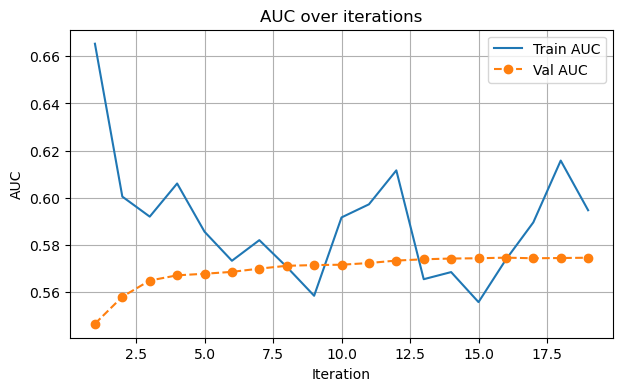

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(train_auc_hist)+1), train_auc_hist, label='Train AUC')
if len(val_auc_hist)>0:
    # 將每 EVAL_EVERY 次的 val AUC 對齊到對應的 iteration（簡單處理）
    xs = np.linspace(EVAL_EVERY, len(train_auc_hist), num=len(val_auc_hist))
    plt.plot(xs, val_auc_hist, label='Val AUC', marker='o', linestyle='--')
plt.xlabel('Iteration'); plt.ylabel('AUC'); plt.title('AUC over iterations'); plt.legend(); plt.grid(True)
plt.show()


定期保存

In [23]:
# ========= 用最佳 checkpoint 做 test 預測 =========
import _pickle as pkl

df_test = pd.read_csv('./dataset/test.csv')
X_test  = featurize_split(df_test['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)
X_test  = normalize(X_test, norm='l2', axis=1, copy=False)   # ★ 與訓練/驗證一致

# 載入最佳模型
clf_best = pkl.load(open(f"{OUT_DIR}/clf-sgd-best.pkl", "rb"))

# 拿機率
test_pred = clf_best.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Popularity': test_pred
})
sub_path = f'{OUT_DIR}/submission_67.csv'
submission.to_csv(sub_path, index=False)
print('Test predictions saved to', sub_path)


Test predictions saved to ./output/submission_67.csv


校準精度

In [ ]:
# ====== 1) 用“最佳”clf在验证集上做概率校准 ======
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import vstack
import numpy as np

# 你前面已经把验证流固化成了 val_batches = list(val_stream)
# 如果你用的是 featurize(...)（比如双通道词+字），就用它；
# 如果你是单个 hashvec，就把下面的 featurize(...) 换成 hashvec.transform(...)

Xv_list, yv_list = [], []
for vb in val_batches:
    Xv_list.append(featurize(vb['Page content']))   # ← 或者：hashvec.transform(vb['Page content'].astype(str))
    yv_list.append(vb['Popularity'].values)

X_val = vstack(Xv_list, format='csr')
y_val = np.concatenate(yv_list)

# 用已训练好的 clf 做“预拟合”校准
# 验证集较小（你设的是 1000），优先用 'sigmoid'(Platt)；'isotonic' 更灵活但容易过拟合
cal_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
cal_clf.fit(X_val, y_val)

# （可选）看看“校准后”的验证 AUC
from sklearn.metrics import roc_auc_score
val_pred_cal = cal_clf.predict_proba(X_val)[:, 1]
print(f"Calibrated Val AUC: {roc_auc_score(y_val, val_pred_cal):.4f}")

# ====== 2) 用校准后的模型生成测试集预测 ======
df_test = pd.read_csv('./dataset/test.csv')
Xt = featurize(df_test['Page content'])             # ← 或者：hashvec.transform(...)
test_pred = cal_clf.predict_proba(Xt)[:, 1]

submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
submission.to_csv('output/submission_46.csv', index=False)
print('Saved: output/submission_46.csv')

# （可选）持久化校准后的模型，之后直接加载 cal_clf 用
import _pickle as pkl, os
os.makedirs('output', exist_ok=True)
pkl.dump(cal_clf, open('output/clf-calibrated.pkl', 'wb'))


k 折

In [ ]:
# =========================
# K 折交叉驗證 + 每折最佳模型集成輸出 test 預測
# =========================
import os, gc, copy, _pickle as pkl
import numpy as np
import pandas as pd
from math import ceil
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from scipy.special import expit
import re
from bs4 import BeautifulSoup

# ---------- 基本配置 ----------
TRAIN_PATH = './dataset/train.csv'
TEST_PATH  = './dataset/test.csv'
OUT_DIR    = './output'
os.makedirs(OUT_DIR, exist_ok=True)

CV_MODE     = 'group'   # 'group' or 'stratified'
N_SPLITS    = 5
EPOCHS      = 3
BATCH_SIZE  = 2000
SEED        = 42
PATIENCE    = 2         # 早停：連續 PATIENCE 個 epoch 無提升就停
DO_FOLD_LDA = False     # True：每折在訓練集上預訓練 LDA（更穩但更慢）

# ---------- 分組鍵提取（publisher） ----------
_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s): return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()
def _slug(s): return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def extract_publisher_slug(html: str) -> str:
    if not isinstance(html, str) or not html.strip():
        return "unknown"
    soup = BeautifulSoup(html, 'html.parser')
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    else:
        publisher = "unknown"
    return _slug(publisher or 'unknown')

# ---------- 分類器工廠（文本穩定配置） ----------
def make_clf():
    return SGDClassifier(
        loss="log_loss",        # 用邏輯損失以獲得 predict_proba
        penalty="elasticnet",
        alpha=1e-5,
        l1_ratio=0.05,
        learning_rate="optimal",
        average=True,
        random_state=SEED
    )

# ---------- 讀取資料 ----------
df = pd.read_csv(TRAIN_PATH)
df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)
y = df['Popularity'].values
texts = df['Page content'].astype(str)

# CV split 準備
if CV_MODE == 'group':
    groups = texts.apply(extract_publisher_slug).values
    splitter = GroupKFold(n_splits=N_SPLITS)
    split_iter = splitter.split(texts, y, groups)
    print(f"Using GroupKFold by publisher (groups={len(np.unique(groups))})")
else:
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    split_iter = splitter.split(texts, y)
    print("Using StratifiedKFold")

# 容器
fold_artifacts = []  # 保存每折最佳模型與（可選）LDA
oof_scores = np.zeros(len(df), dtype=float)
fold_aucs, fold_epochs = [], []

print(f"\nStart {N_SPLITS}-fold CV: EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, DO_FOLD_LDA={DO_FOLD_LDA}")

for fold, (tr_idx, va_idx) in enumerate(split_iter, start=1):
    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")
    tr_df = df.iloc[tr_idx].reset_index(drop=True)
    va_df = df.iloc[va_idx].reset_index(drop=True)
    y_val = va_df['Popularity'].values

    # 每折 LDA（可選，避免外洩需在訓練集上建）
    if DO_FOLD_LDA:
        lda_vec_f, lda_mod_f = pretrain_lda(tr_df, column='Page content', n_components=10, max_features=1000)
    else:
        lda_vec_f, lda_mod_f = (None, None)

    # 固定本折驗證特徵
    X_val = featurize_split(va_df['Page content'].astype(str), lda_vec_f, lda_mod_f, n_jobs=1)

    # 模型與早停
    clf = make_clf()
    best_auc, best_epoch = -1, -1
    best_state = None
    no_improve = 0

    # 多 epoch 訓練
    for epoch in range(1, EPOCHS+1):
        tr_shuf = tr_df.sample(frac=1.0, random_state=SEED+epoch).reset_index(drop=True)
        n_batches = ceil(len(tr_shuf)/BATCH_SIZE)

        for b in range(n_batches):
            batch = tr_shuf.iloc[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
            X_tr = featurize_split(batch['Page content'].astype(str), lda_vec_f, lda_mod_f, n_jobs=1)
            y_tr = batch['Popularity'].values
            if epoch == 1 and b == 0:
                clf.partial_fit(X_tr, y_tr, classes=np.array([0,1]))
            else:
                clf.partial_fit(X_tr, y_tr)

        # epoch 結束：評估本折 Val
        if hasattr(clf, "predict_proba"):
            val_prob = clf.predict_proba(X_val)[:, 1]
        else:
            val_prob = expit(clf.decision_function(X_val))
        val_auc = roc_auc_score(y_val, val_prob)
        print(f"Fold {fold} | epoch {epoch}/{EPOCHS} | Val AUC={val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_epoch = epoch
            best_state = copy.deepcopy(clf)
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"  Early stopping at epoch {epoch} (no improve {PATIENCE}×)")
                break

    # 保存 OOF（用最佳狀態）
    if hasattr(best_state, "predict_proba"):
        oof_scores[va_idx] = best_state.predict_proba(X_val)[:, 1]
    else:
        oof_scores[va_idx] = expit(best_state.decision_function(X_val))

    fold_aucs.append(best_auc); fold_epochs.append(best_epoch)

    # 保存每折最佳模型到硬碟
    model_path = os.path.join(OUT_DIR, f'clf_sgd_fold{fold}.pkl')
    pkl.dump(best_state, open(model_path, 'wb'))

    # 若用了 LDA，順便把該折的 LDA 也存起來
    lda_path = None
    if DO_FOLD_LDA:
        lda_path = os.path.join(OUT_DIR, f'lda_fold{fold}.pkl')
        pkl.dump({'lda_vec': lda_vec_f, 'lda_model': lda_mod_f}, open(lda_path, 'wb'))

    fold_artifacts.append({
        'model_path': model_path,
        'lda_path': lda_path
    })
    print(f"Fold {fold} BEST: epoch={best_epoch}, AUC={best_auc:.4f} | saved {model_path}")

    del X_val; gc.collect()

# CV 總結
oof_auc = roc_auc_score(y, oof_scores)
print("\n========== CV Summary ==========")
print("Fold AUCs:", ["%.4f" % a for a in fold_aucs])
print("Mean AUC = %.4f | Std = %.4f" % (np.mean(fold_aucs), np.std(fold_aucs)))
print("OOF  AUC = %.4f" % oof_auc)

# ---------- 用每折最佳模型對 test 預測並平均 ----------
df_test = pd.read_csv(TEST_PATH)
test_texts = df_test['Page content'].astype(str)
test_preds_each_fold = []

for fold, art in enumerate(fold_artifacts, start=1):
    # 讀模型
    clf = pkl.load(open(art['model_path'], 'rb'))
    # 讀折內 LDA（可選）
    if DO_FOLD_LDA and art['lda_path'] is not None:
        lda_pack = pkl.load(open(art['lda_path'], 'rb'))
        lda_vec_f, lda_mod_f = lda_pack['lda_vec'], lda_pack['lda_model']
    else:
        lda_vec_f, lda_mod_f = (None, None)

    # 特徵化（若各折 LDA 不同，需各自 transform 一次）
    X_test = featurize_split(test_texts, lda_vec_f, lda_mod_f, n_jobs=1)

    # 預測機率
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_test)[:, 1]
    else:
        prob = expit(clf.decision_function(X_test))
    test_preds_each_fold.append(prob)
    print(f"Fold {fold} test predicted. Shape={prob.shape}")

# 集成（平均）
test_pred = np.mean(np.vstack(test_preds_each_fold), axis=0)

# 導出提交
sub_path = os.path.join(OUT_DIR, f'submission_k{N_SPLITS}_ens.csv')
pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred}).to_csv(sub_path, index=False)
print("Submission saved ->", sub_path)


In [32]:
# ==== 2) （可在新會話）加载并推理 test ====
import os, _pickle as pkl
import numpy as np
import pandas as pd
from scipy.special import expit  # 稳定的 sigmoid

# 确保 featurize_split(...) 和 preprocessor(...) 以及所有向量器配置
# （HashingVectorizer/FeatureHasher 的 n_features、ngram_range 等）
# 已按「訓練時的設定」在當前會話中定義好！

# 1) 改這一行：讀入你要用的折模型
clf = pkl.load(open('output/clf_sgd_fold3.pkl', 'rb'))

# 2) 如果你有保存 LDA（全局一份）：沿用；如果是每折 LDA，換成 'output/lda_fold3.pkl'
lda_pack_path = 'output/lda.pkl'  # 或 'output/lda_fold3.pkl'
if os.path.exists(lda_pack_path):
    lda_pack = pkl.load(open(lda_pack_path, 'rb'))
    lda_vectorizer = lda_pack.get('lda_vec', None)
    lda_model      = lda_pack.get('lda_model', None)
else:
    lda_vectorizer = None
    lda_model      = None

# 3) 讀 test
df_test = pd.read_csv('./dataset/test.csv')

# 4) 特徵化（務必與訓練一致）
X_test = featurize_split(df_test['Page content'].astype(str), lda_vectorizer, lda_model)

# 如果訓練時還有全局 TF-IDF / 行 L2 歸一化，這裡也要載入並套用：
# try:
#     tfidf = pkl.load(open('output/tfidf.pkl','rb'))
#     from sklearn.preprocessing import normalize
#     X_test = tfidf.transform(X_test)
#     X_test = normalize(X_test, norm='l2', axis=1, copy=False)
# except Exception:
#     pass

# 5) 出機率
if hasattr(clf, "predict_proba"):
    test_pred = clf.predict_proba(X_test)[:, 1]
else:
    # hinge / squared_hinge 沒有 predict_proba，用 decision_function 經 sigmoid 得到“伪概率”
    test_pred = expit(clf.decision_function(X_test))

# 6) 輸出提交檔
submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
os.makedirs('output', exist_ok=True)
submission.to_csv('output/submission_68.csv', index=False)
print('Test predictions saved to output/submission_68.csv')


Test predictions saved to output/submission_68.csv
